# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

----
# 0. Preparation
Import necessary libraries and create a Spark session.



In [110]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import warnings
import seaborn as sns
import datetime
from time import time

import pyspark
import pyspark.sql.functions as F
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, isnan, when, count
from pyspark.sql.types import IntegerType, LongType

from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from pyspark.mllib.evaluation import MulticlassMetrics

%matplotlib inline

In [4]:
# create requirements.txt - only run when changing libraries
#! pip freeze > requirements.txt

In [5]:
# set style for visualizations
plt.style.use('ggplot')

In [6]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

----
# 1. Project Definition

## 1.1 Project Overview
This project is the final Capstone project of the Udacity Data Scientist Nanodegree program. The aim is to learn how to manipulate realistic datasets with Spark to engineer relevant features for predicting churn. Input data is related to the fictive music streaming service Sparkify (similar to Spotify and Pandora). The full dataset was only available if paying for an account in AWS so this project have been done using the workspace provided by Udacity. A smaller dataset was provided in .json format. 

## 1.2 Problem Statement
The problem is to predict which users will churn from the Sparkify music streaming service. I will build a machine learning model using Spark to achieve this. As there only are two possible outcomes, 'churn' and 'not churn', this is a binary classification problem where we can apply supervised learning.

# 1.3 Metrics
Only 23% of the users have the outcome churn and therefore the classification distribution is unbalanced. To take this into account I've chosen the **F1 Score** metric which is the harmonic mean of precision and recall.

----
# 2. Analysis

## 2.1 Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`.

### 2.1.1 Load Data

In [7]:
# load dataset
path = "mini_sparkify_event_data.json"
event_log = spark.read.json(path)

### 2.1.2 Clean Data
The following were found when cleaning the data:
- There are some rows with missing data and one string column with no values (userId).
- Looks like most columns with missing data is when a user is not logged in and is browsing the web page of the service.
- When filtering out the empty userId we only lose "one" user (all the unknowns).
- After filtering out empty userID there are 50046 rows with missing data for 3 columns which all are related to a song (artist, length, song). This is natural since the user can do other events than listening to songs while logged in. Since we are interested in these other events as well, these rows were not removed.

In [8]:
# count rows
event_log.count()

286500

In [9]:
# distinct users
event_log.select(F.countDistinct("userId")).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   226|
+----------------------+



In [10]:
# check which columns exist
event_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [11]:
# check for missing values
event_log.select([count(when(isnan(c) | col(c).isNull(), c)) \
         .alias(c) for c in event_log.columns]) \
         .collect()

[Row(artist=58392, auth=0, firstName=8346, gender=8346, itemInSession=0, lastName=8346, length=58392, level=0, location=8346, method=0, page=0, registration=8346, sessionId=0, song=58392, status=0, ts=0, userAgent=8346, userId=0)]

In [12]:
# check min values for string columns - first part
event_log.select(["artist", "auth", "firstName", "gender", "lastName", "level"]) \
         .describe() \
         .show()

+-------+------------------+----------+---------+------+--------+------+
|summary|            artist|      auth|firstName|gender|lastName| level|
+-------+------------------+----------+---------+------+--------+------+
|  count|            228108|    286500|   278154|278154|  278154|286500|
|   mean| 551.0852017937219|      null|     null|  null|    null|  null|
| stddev|1217.7693079161374|      null|     null|  null|    null|  null|
|    min|               !!!| Cancelled| Adelaida|     F|   Adams|  free|
|    max| ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|  Wright|  paid|
+-------+------------------+----------+---------+------+--------+------+



In [13]:
# check min values for string columns - second part
event_log.select(["location", "method", "page", "song", "userAgent", "userId"]) \
         .describe() \
         .show()

+-------+-----------------+------+-------+--------------------+--------------------+-----------------+
|summary|         location|method|   page|                song|           userAgent|           userId|
+-------+-----------------+------+-------+--------------------+--------------------+-----------------+
|  count|           278154|286500| 286500|              228108|              278154|           286500|
|   mean|             null|  null|   null|            Infinity|                null|59682.02278593872|
| stddev|             null|  null|   null|                 NaN|                null|109091.9499991047|
|    min|       Albany, OR|   GET|  About|ÃÂg ÃÂtti Gr...|"Mozilla/5.0 (Mac...|                 |
|    max|Winston-Salem, NC|   PUT|Upgrade|ÃÂau hafa slopp...|Mozilla/5.0 (comp...|               99|
+-------+-----------------+------+-------+--------------------+--------------------+-----------------+



In [14]:
# see examples of missing userId
event_log.filter("userId = ''").show(3)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET|Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355841000|     null|      |
+------+----------+---------+------+----

In [15]:
# remove rows with empty userId
event_log_valid = event_log.filter(event_log["userId"] != "")

In [16]:
# check for missing values again after removing empty userId
event_log_valid.select([count(when(isnan(c) | col(c).isNull(), c)) \
               .alias(c) for c in event_log_valid.columns]) \
               .collect()

[Row(artist=50046, auth=0, firstName=0, gender=0, itemInSession=0, lastName=0, length=50046, level=0, location=0, method=0, page=0, registration=0, sessionId=0, song=50046, status=0, ts=0, userAgent=0, userId=0)]

In [17]:
# count rows after removing empty userId
event_log_valid.count()

278154

In [18]:
# distinct users
event_log_valid.select(F.countDistinct("userId")).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



## 2.2 Exploratory Data Analysis

### 2.2.1 Preliminary Analysis

#### 2.2.1.1 Column Description
As no file description or data dictionary was provided, the following were assumed based on analysing the data:

| Column | Grain | Description |
| --- | :- | :- |
| artist | Song | The artist name of the song played. |
| auth | Event | Indicate if the user is logged in or not. |
| firstName | User | First name of user. This could be considered a sensitive field in terms of data privacy. See discussion in next session about ethics. |
| gender | User | If the user is Male or Female. |
| itemInSession | Event | Which order in the session the event occurred. |
| lastName | User | Last name of user. This could be considered a sensitive field in terms of data privacy. See discussion in next session about ethics. |
| length | Song | Song length in seconds. |
| level | Event | If the user had a free or paid subscription to the service at the time of the event. |
| location | Session | Location of userAgent for session. |
| method | Event | HTTP method used, can be GET or PUT. |
| page | Event | The type of the event. |
| registration | User | Timestamp for when the user first registered for the service. |
| sessionId | Session | Unique identifier of a session. |
| song | Song | The title of the song. |
| status | Event | HTTP status code. 2xx=Successful, 3xx=Redirection, 4xx=Client Error. |
| ts | Event | Timestamp of the event. |
| userAgent | Session | The environment for the user, example OS and web browser used. |
| userId | User | Unique identifier of a user. |


In [19]:
# check some example values
pd.DataFrame(data=event_log_valid.head(4), columns=event_log_valid.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9


In [20]:
# distribution of auth
event_log_valid.groupBy("auth").count().orderBy("auth").show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [21]:
# distribution of gender
event_log_valid.groupBy("gender").count().orderBy("gender").show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [22]:
# distribution of level
event_log_valid.groupBy("level").count().orderBy("level").show()

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+



In [23]:
# distribution of method
event_log_valid.groupBy("method").count().orderBy("method").show()

+------+------+
|method| count|
+------+------+
|   GET| 20336|
|   PUT|257818|
+------+------+



In [24]:
# examples of page
event_log_valid.groupBy("page").count().orderBy("page").show()

+--------------------+------+
|                page| count|
+--------------------+------+
|               About|   495|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|              Cancel|    52|
|Cancellation Conf...|    52|
|           Downgrade|  2055|
|               Error|   252|
|                Help|  1454|
|                Home| 10082|
|              Logout|  3226|
|            NextSong|228108|
|         Roll Advert|  3933|
|       Save Settings|   310|
|            Settings|  1514|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|         Thumbs Down|  2546|
|           Thumbs Up| 12551|
|             Upgrade|   499|
+--------------------+------+



In [25]:
# examples of status
event_log_valid.groupBy("status").count().orderBy("status").show()

+------+------+
|status| count|
+------+------+
|   200|254718|
|   307| 23184|
|   404|   252|
+------+------+



#### 2.2.1.2 Ethics
There are a few columns in the source data that could be considered containing sensitive data. Especially the 'firstName' and 'lastName' columns could violate the privacy of the users. Those fields in combination with other columns like the gender, location and what type of music a user is listening to might reveal personal things about an user. 

Even though I've assumed that this is fictive data, I've chosen not to use these fields for this project.

### 2.2.2 Add Time Variables
Adding a few time variables which makes it easier to analyze the data.

In [26]:
# define functions
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). year, IntegerType())
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month, IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day, IntegerType())
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour, IntegerType())
get_yearMonth = udf(lambda x,y: (x * 100) + y, IntegerType())

In [27]:
# add time variables
event_log_valid = event_log_valid.withColumn("year", get_year(event_log_valid.ts))
event_log_valid = event_log_valid.withColumn("month", get_month(event_log_valid.ts))
event_log_valid = event_log_valid.withColumn("day", get_day(event_log_valid.ts))
event_log_valid = event_log_valid.withColumn("hour", get_hour(event_log_valid.ts))
event_log_valid = event_log_valid.withColumn("yearMonth", get_yearMonth(event_log_valid.year, event_log_valid.month))

In [28]:
# check example
event_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', year=2018, month=10, day=1, hour=0, yearMonth=201810)

In [29]:
# calculate statistics by Month
event_log_valid.groupby([event_log_valid.year, event_log_valid.month]).count() \
               .orderBy([event_log_valid.year, event_log_valid.month]) \
               .show()

+----+-----+------+
|year|month| count|
+----+-----+------+
|2018|   10|144916|
|2018|   11|133234|
|2018|   12|     4|
+----+-----+------+



### 2.2.3 Define Churn
Churn is defined as when the page status is equal to 'Cancellation Confirmation'. This can happen for both paid and free users.

In [30]:
# find churn example
event_log_valid.filter("page = 'Cancellation Confirmation'").show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+-----+---+----+---------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|year|month|day|hour|yearMonth|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+-----+---+----+---------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|2018|   10|  7|  20|   201810|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-

In [31]:
# show events for example user
event_log_valid.select(["userId", "ts", "year", "month", "day", "page", "level"]) \
               .where((event_log_valid.userId == "32") & (event_log_valid.ts > 1539032608000)) \
               .show(5)

+------+-------------+----+-----+---+--------------------+-----+
|userId|           ts|year|month|day|                page|level|
+------+-------------+----+-----+---+--------------------+-----+
|    32|1539032741000|2018|   10|  8|            NextSong| paid|
|    32|1539032978000|2018|   10|  8|            NextSong| paid|
|    32|1539033030000|2018|   10|  8|           Downgrade| paid|
|    32|1539033031000|2018|   10|  8|              Cancel| paid|
|    32|1539033046000|2018|   10|  8|Cancellation Conf...| paid|
+------+-------------+----+-----+---+--------------------+-----+



In [32]:
# function for flagging churn
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [33]:
# add churn variable
event_log_valid = event_log_valid.withColumn("churn", flag_churn_event("page"))

# check example
event_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', year=2018, month=10, day=1, hour=0, yearMonth=201810, churn=0)

In [34]:
# show events for example user including churn column
event_log_valid.select(["userId", "year", "month", "day", "page", "level", "churn"]) \
               .where((event_log_valid.userId == "32") & (event_log_valid.ts > 1539032608000)) \
               .show(5)

+------+----+-----+---+--------------------+-----+-----+
|userId|year|month|day|                page|level|churn|
+------+----+-----+---+--------------------+-----+-----+
|    32|2018|   10|  8|            NextSong| paid|    0|
|    32|2018|   10|  8|            NextSong| paid|    0|
|    32|2018|   10|  8|           Downgrade| paid|    0|
|    32|2018|   10|  8|              Cancel| paid|    0|
|    32|2018|   10|  8|Cancellation Conf...| paid|    1|
+------+----+-----+---+--------------------+-----+-----+



### 2.2.4 Explore Data

#### 2.2.4.1 General

In [35]:
# check which columns exist
event_log_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- yearMonth: integer (nullable = true)
 |-- churn: integer (nullable = true)



In [36]:
# check statistics for numeric columns
num_cols = ["itemInSession", "length", "registration", "sessionId", 
            "status", "ts", "churn", "year", "month", "day", "hour", "yearMonth"]
num_desc = event_log_valid.select(num_cols).describe()
num_desc_pd = num_desc.toPandas()
num_desc_pd

,summary,itemInSession,length,registration,sessionId,status,ts,churn,year,month,day,hour,yearMonth
0,count,278154,228108,278154,278154,278154,278154,278154,278154,278154,278154,278154,278154
1,mean,114.89918174824018,249.1171819778458,1.5353588340844272E12,1042.5616241362698,209.10321620397335,1.5409589154318713E12,1.869467992550889E-4,2018.0,10.479022412045126,15.793574782314833,12.20457372534639,201810.47902241204
2,stddev,129.851729399489,99.23517921058361,3.291321616327586E9,726.5010362219813,30.151388851328214,1.5068287123306298E9,0.013671595449116164,0.0,0.4995894305896185,8.926525825029135,6.865469990132577,0.49958942988950344
3,min,0,0.78322,1521380675000,1,200,1538352117000,0,2018,10,1,0,201810
4,max,1321,3024.66567,1543247354000,2474,404,1543799476000,1,2018,12,31,23,201812


#### 2.2.4.2 yearMonth
The dataset only contains two months of data (only 4 rows for the third month) which makes it hard to create features that take into account trends.

In [37]:
# calculate statistics by year and month
year_month = event_log_valid.groupby([event_log_valid.yearMonth]) \
                           .count() \
                           .orderBy([event_log_valid.yearMonth]) 

# convert to pandas df
year_month_pd = year_month.toPandas()
year_month_pd

,yearMonth,count
0,201810,144916
1,201811,133234
2,201812,4


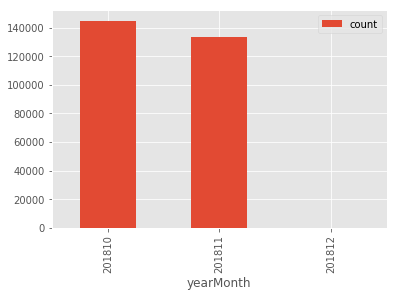

In [38]:
# visualize frequency over time
year_month_pd.plot.bar(x='yearMonth', y='count', color='C0')
plt.show()

#### 2.2.4.3 Churn
As we can see, the churn target variable is unbalanced since around 23% of all users having churned (52 / 225).

In [39]:
# aggregate churn by event
events_in_churn = event_log_valid.groupby(event_log_valid.churn).count() \
                                 .orderBy(event_log_valid.churn)
events_in_churn.show()

+-----+------+
|churn| count|
+-----+------+
|    0|278102|
|    1|    52|
+-----+------+



In [40]:
# aggregate churn by userId
users_in_churn = event_log_valid.groupby(event_log_valid.userId,
                                         event_log_valid.gender).agg({"churn": "max"}) 

# rename aggregated columns
users_in_churn = users_in_churn.select(col("userId"),
                                       col("gender"),
                                       col("max(churn)").alias("churn"))

# show examples
users_in_churn.show(5)

+------+------+-----+
|userId|gender|churn|
+------+------+-----+
|    44|     F|    0|
|    46|     F|    0|
|    41|     F|    0|
|    72|     F|    0|
|300023|     F|    0|
+------+------+-----+
only showing top 5 rows



In [41]:
# distribution by churn
dist_churn = users_in_churn.groupby(users_in_churn.churn) \
                           .count() \
                           .orderBy(users_in_churn.churn)
dist_churn_pd = dist_churn.toPandas()
dist_churn_pd

,churn,count
0,0,173
1,1,52


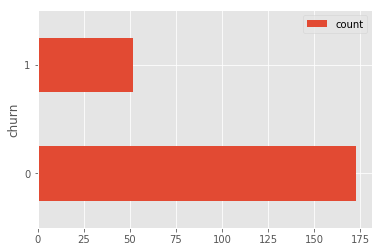

In [42]:
# visualize churn distribution
dist_churn_pd.plot.barh(x='churn', y='count', color='C0')
plt.show()

#### 2.2.4.4 User Gender by Churn
Looks like females are slightly less likely to churn.

In [43]:
# distribution by churn
dist_churn_gender = users_in_churn.groupby(users_in_churn.churn, users_in_churn.gender) \
                           .count() \
                           .orderBy(users_in_churn.churn)
dist_churn_gender_pd = dist_churn_gender.toPandas()

# visualize churn distribution
dist_churn_gender_pd.head()

,churn,gender,count
0,0,M,89
1,0,F,84
2,1,F,20
3,1,M,32


#### 2.2.4.5 User Songs Played by Churn
We see that if a user has listened to a large number of songs it's unlikely they will churn.

In [44]:
# define function to flag songs
flag_song = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())

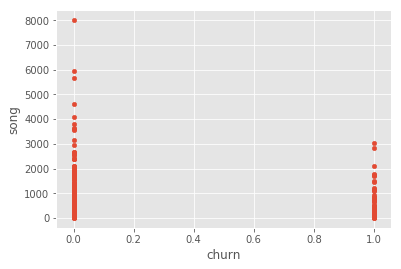

In [45]:
# add songs variable
event_log_valid = event_log_valid.withColumn("song", flag_song("page"))

# aggregate churn by userId
user_song = event_log_valid.groupby(event_log_valid.userId).agg({"churn": "max",
                                                                 "song": "sum"}) 

# rename aggregated columns
user_song = user_song.select(col("userId"),
                             col("max(churn)").alias("churn"),
                             col("sum(song)").alias("song"))

# convert to pandas and visualize
user_song_pd = user_song.toPandas()
user_song_pd.plot.scatter(x='churn', y='song', color='C0')
plt.show()

----
# 3. Methodology

## 3.1 Data Preprocessing

### 3.1.1 Limit Columns
Filter out columns not needed further on.

In [46]:
# display all available columns
event_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song=1, status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', year=2018, month=10, day=1, hour=0, yearMonth=201810, churn=0)

In [47]:
# filter to only include columns needed
event = event_log_valid.select(["userId", "gender", "level", "page", "registration", "sessionId", "ts", "churn"])

# display example
event.show(1)

+------+------+-----+--------+-------------+---------+-------------+-----+
|userId|gender|level|    page| registration|sessionId|           ts|churn|
+------+------+-----+--------+-------------+---------+-------------+-----+
|    30|     M| paid|NextSong|1538173362000|       29|1538352117000|    0|
+------+------+-----+--------+-------------+---------+-------------+-----+
only showing top 1 row



### 3.1.2 Feature Engineering
Create new features derived from available data. The following features were created:

| Type | Feature | Description |
| --- | :- | :- |
| Categorical | downgraded | Indicate if a user have ever downgraded from the paid service to the free service. |
| Categorical | gender_male | Indicate if a user is male. |
| Categorical | level_paid | Indicate if a user has paid for the service at some point in time. |
| Continuous | timeSinceRegistration | Difference between last event and registration for a user. |
| Continuous | playlistSongs | Number of songs that have been added to playlists for a user. |
| Continuous | thumbsUp | Number of thumbs up events for a user. |
| Continuous | thumbsDown | Number of thumbs down events for a user. |
| Continuous | song | Average number of songs a user listened to during a session. |

#### 3.1.2.1 downgraded

In [48]:
# define function
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [49]:
# add downgrade variable
event = event.withColumn("downgraded", flag_downgrade_event("page"))
event.select(["userId", "ts", "page", "downgraded"]).where(event.userId == "32").show(3)

+------+-------------+--------+----------+
|userId|           ts|    page|downgraded|
+------+-------------+--------+----------+
|    32|1538578897000|NextSong|         0|
|    32|1538579134000|NextSong|         0|
|    32|1538579540000|NextSong|         0|
+------+-------------+--------+----------+
only showing top 3 rows



#### 3.1.2.2 gender_male


In [50]:
# define function
flag_gender = udf(lambda x: 1 if x == "M" else 0, IntegerType())

In [51]:
# add gender variable
event = event.withColumn("gender_male", flag_gender("gender"))
event.select(["userId", "gender", "gender_male"]).where(event.userId == "32").show(1)

+------+------+-----------+
|userId|gender|gender_male|
+------+------+-----------+
|    32|     M|          1|
+------+------+-----------+
only showing top 1 row



#### 3.1.2.3 level_paid
Flag if the user has paid for the service at some point in time.

In [52]:
# define function
flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())

In [53]:
# add gender variable
event = event.withColumn("level_paid", flag_level("level"))
event.select(["userId", "ts", "level", "level_paid"]).where(event.userId == "30").show(3)

+------+-------------+-----+----------+
|userId|           ts|level|level_paid|
+------+-------------+-----+----------+
|    30|1538352117000| paid|         1|
|    30|1538352394000| paid|         1|
|    30|1538352676000| paid|         1|
+------+-------------+-----+----------+
only showing top 3 rows



#### 3.1.2.4 timeSinceRegistration

In [54]:
# define function
calculate_time = udf(lambda x,y: x-y if x>=y else 0, LongType())

In [55]:
# add gender variable
event = event.withColumn("timeSinceRegistration", calculate_time("ts", "registration"))
event.select(["userId", "ts", "registration", "timeSinceRegistration"]).where(event.userId == "32").show(3)

+------+-------------+-------------+---------------------+
|userId|           ts| registration|timeSinceRegistration|
+------+-------------+-------------+---------------------+
|    32|1538578897000|1537167593000|           1411304000|
|    32|1538579134000|1537167593000|           1411541000|
|    32|1538579540000|1537167593000|           1411947000|
+------+-------------+-------------+---------------------+
only showing top 3 rows



#### 3.1.2.5 playlistSongs

In [56]:
# define function
flag_playlist_event = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())

In [57]:
# add playlist variable
event = event.withColumn("playlistSongs", flag_playlist_event("page"))
event.select(["userId", "ts", "page", "playlistSongs"]).where(event.userId == "32").show(10)

+------+-------------+---------------+-------------+
|userId|           ts|           page|playlistSongs|
+------+-------------+---------------+-------------+
|    32|1538578897000|       NextSong|            0|
|    32|1538579134000|       NextSong|            0|
|    32|1538579540000|       NextSong|            0|
|    32|1538579565000|    Roll Advert|            0|
|    32|1538579814000|       NextSong|            0|
|    32|1538579815000|      Thumbs Up|            0|
|    32|1538580056000|       NextSong|            0|
|    32|1538580068000|Add to Playlist|            1|
|    32|1538580267000|       NextSong|            0|
|    32|1538580477000|       NextSong|            0|
+------+-------------+---------------+-------------+
only showing top 10 rows



#### 3.1.2.6 thumbsUp

In [58]:
# define function
flag_thumbs_up = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

In [59]:
# add thumbs variables
event = event.withColumn("thumbsUp", flag_thumbs_up("page"))
event.select(["userId", "ts", "page", "thumbsUp"]).where(event.userId == "32").show(6)

+------+-------------+-----------+--------+
|userId|           ts|       page|thumbsUp|
+------+-------------+-----------+--------+
|    32|1538578897000|   NextSong|       0|
|    32|1538579134000|   NextSong|       0|
|    32|1538579540000|   NextSong|       0|
|    32|1538579565000|Roll Advert|       0|
|    32|1538579814000|   NextSong|       0|
|    32|1538579815000|  Thumbs Up|       1|
+------+-------------+-----------+--------+
only showing top 6 rows



#### 3.1.2.7 thumbsDown

In [60]:
# define function
flag_thumbs_down = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

In [61]:
# add thumbs variables
event = event.withColumn("thumbsDown", flag_thumbs_down("page"))
event.select(["userId", "ts", "page", "thumbsDown"]).where(event.userId == "36").show(3)

+------+-------------+-----------+----------+
|userId|           ts|       page|thumbsDown|
+------+-------------+-----------+----------+
|    36|1538391194000|       Home|         0|
|    36|1538391272000|   NextSong|         0|
|    36|1538391273000|Thumbs Down|         1|
+------+-------------+-----------+----------+
only showing top 3 rows



#### 3.1.2.8 song

In [62]:
# define function
flag_song = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())

In [63]:
# add songs variable
event = event.withColumn("song", flag_song("page"))
event.select(["userId", "sessionId", "ts", "page", "song"]).where(event.userId == "32").show(5)

+------+---------+-------------+-----------+----+
|userId|sessionId|           ts|       page|song|
+------+---------+-------------+-----------+----+
|    32|      218|1538578897000|   NextSong|   1|
|    32|      218|1538579134000|   NextSong|   1|
|    32|      218|1538579540000|   NextSong|   1|
|    32|      218|1538579565000|Roll Advert|   0|
|    32|      218|1538579814000|   NextSong|   1|
+------+---------+-------------+-----------+----+
only showing top 5 rows



### 3.1.3 Create Session Features
Aggregate the features that should be per session.

In [64]:
# aggregate by userId & sessionId
session = event.groupby(event.userId, event.sessionId).agg({"song": "sum"}) 

# rename aggregated columns
session = session.select(col("userId"),
                         col("sessionId"),
                         col("sum(song)").alias("song"))

# present result
session.show(5)

+------+---------+----+
|userId|sessionId|song|
+------+---------+----+
|    92|      358|  57|
|    42|      433|  16|
|   101|      635| 708|
|   120|      627| 236|
|   140|      798|   3|
+------+---------+----+
only showing top 5 rows



### 3.1.4 Aggregate Features
Aggregate all features up to user level since we want to predict churn based on users.

#### 3.1.4.1 Session Features
Aggregate session level variables up to user level.

In [65]:
# aggregate by userId
features_session = session.groupby(session.userId).agg({"song": "avg"}) 

# rename aggregated columns
features_session = features_session.select(col("userId"),
                                           F.round(col("avg(song)"), 1).alias("song"))

# present result
features_session.show(5)

+------+-----+
|userId| song|
+------+-----+
|100010| 39.3|
|200002| 64.5|
|   125|  8.0|
|    51|211.1|
|   124|140.7|
+------+-----+
only showing top 5 rows



#### 3.1.4.2 Event Features
Aggregate event level variables up to user level.

In [66]:
# aggregate by userId
features_event = event.groupby(event.userId).agg({"downgraded": "max", 
                                                  "gender_male": "max",
                                                  "level_paid": "max",
                                                  "timeSinceRegistration": "max",
                                                  "playlistSongs": "sum",
                                                  "thumbsUp": "sum",
                                                  "thumbsDown": "sum",
                                                  "churn": "max"}) 

# rename aggregated columns
features_event = features_event.select(col("userId"),
                                       col("max(downgraded)").alias("downgraded"),
                                       col("max(gender_male)").alias("gender_male"),
                                       col("max(level_paid)").alias("level_paid"),
                                       col("max(timeSinceRegistration)").alias("timeSinceRegistration"),
                                       col("sum(playlistSongs)").alias("playlistSongs"),
                                       col("sum(thumbsUp)").alias("thumbsUp"),
                                       col("sum(thumbsDown)").alias("thumbsDown"),
                                       col("max(churn)").alias("churn"))

# present result
features_event.show(5)

+------+----------+-----------+----------+---------------------+-------------+--------+----------+-----+
|userId|downgraded|gender_male|level_paid|timeSinceRegistration|playlistSongs|thumbsUp|thumbsDown|churn|
+------+----------+-----------+----------+---------------------+-------------+--------+----------+-----+
|100010|         0|          0|         0|           4807612000|            7|      17|         5|    0|
|200002|         0|          1|         1|           6054448000|            8|      21|         6|    0|
|   125|         0|          1|         0|           6161779000|            0|       0|         0|    1|
|    51|         0|          1|         1|           1680985000|           52|     100|        21|    1|
|   124|         0|          0|         1|          11366431000|          118|     171|        41|    0|
+------+----------+-----------+----------+---------------------+-------------+--------+----------+-----+
only showing top 5 rows



### 3.1.5 Combine All Features
Combine both features coming from session and event to create one final dataset ready to be used in the modelling.

In [67]:
# join all features
df1 = features_event.alias('df1')
df2 = features_session.alias('df2')
features = df1.join(df2, df1.userId == df2.userId, 'left_outer') \
              .select('df1.*', 'df2.song') \
              .drop(df1.userId)

# check examples
features.show(5)

+----------+-----------+----------+---------------------+-------------+--------+----------+-----+-----+
|downgraded|gender_male|level_paid|timeSinceRegistration|playlistSongs|thumbsUp|thumbsDown|churn| song|
+----------+-----------+----------+---------------------+-------------+--------+----------+-----+-----+
|         0|          0|         0|           4807612000|            7|      17|         5|    0| 39.3|
|         0|          1|         1|           6054448000|            8|      21|         6|    0| 64.5|
|         0|          1|         0|           6161779000|            0|       0|         0|    1|  8.0|
|         0|          0|         1|          11366431000|          118|     171|        41|    0|140.7|
|         0|          1|         1|           1680985000|           52|     100|        21|    1|211.1|
+----------+-----------+----------+---------------------+-------------+--------+----------+-----+-----+
only showing top 5 rows



In [68]:
# check datatypes
features.printSchema()

root
 |-- downgraded: integer (nullable = true)
 |-- gender_male: integer (nullable = true)
 |-- level_paid: integer (nullable = true)
 |-- timeSinceRegistration: long (nullable = true)
 |-- playlistSongs: long (nullable = true)
 |-- thumbsUp: long (nullable = true)
 |-- thumbsDown: long (nullable = true)
 |-- churn: integer (nullable = true)
 |-- song: double (nullable = true)



In [69]:
# display size
features.count()

225

In [70]:
# Check average feature value for each target value
features_pd = features.toPandas()
features_pd.groupby('churn').mean()

,downgraded,gender_male,level_paid,timeSinceRegistration,playlistSongs,thumbsUp,thumbsDown,song
churn,,,,,,,,
0,0.231214,0.514451,0.745665,7.484022e+09,31.722543,61.803468,11.849711,71.168786
1,0.173077,0.615385,0.692308,4.951238e+09,19.961538,35.750000,9.538462,61.813462


In [71]:
# statistics for all features
features_pd.describe()

,downgraded,gender_male,level_paid,timeSinceRegistration,playlistSongs,thumbsUp,thumbsDown,churn,song
count,225.000000,225.000000,225.000000,2.250000e+02,225.000000,225.000000,225.000000,225.000000,225.000000
mean,0.217778,0.537778,0.733333,6.898667e+09,29.004444,55.782222,11.315556,0.231111,69.006667
std,0.413656,0.499682,0.443203,3.253951e+09,32.716654,65.477925,13.077481,0.422483,42.321477
min,0.000000,0.000000,0.000000,2.710600e+07,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.000000,0.000000,0.000000,5.108474e+09,6.000000,11.000000,2.000000,0.000000,35.900000
50%,0.000000,1.000000,1.000000,6.307591e+09,17.000000,35.000000,7.000000,0.000000,64.200000
75%,0.000000,1.000000,1.000000,8.672693e+09,44.000000,81.000000,16.000000,0.000000,91.700000
max,1.000000,1.000000,1.000000,2.215103e+10,240.000000,437.000000,75.000000,1.000000,286.700000


### 3.1.6 Handle Outliers
Check the continuous features for outliers and then apply log transformation.

In [72]:
def check_distribution(df, columns):
    '''
    Plot a histogram with boxplot for each listed column in dataframe.
    
    INPUT:
    (dataframe) df - pandas dataframe
    (list) columns - list of column names to be plotted
    
    OUTPUT:
    None
    '''
     # Set variables
    row_size = 1
    column_size = len(columns)
    f_width = column_size*3
    f_height = 4
    plot_counter = 0

    # Set figure size
    fig = plt.figure(figsize = [f_width, f_height])

    # create a 2 X column_size grid 
    gs = grd.GridSpec(2, column_size, height_ratios=[8,2], width_ratios=None, hspace=0.3, wspace=0.6)

    # Plot each column
    for column in columns:
        
        # Find min and max for x
        column_min = df[column].min()
        column_max = df[column].max()
        column_range = df[column].max() - df[column].min()
        min_x = df[column].min() - (column_range / 20)
        max_x = df[column].max() + (column_range / 20)
        
        # Histogram plot
        ax = plt.subplot(gs[plot_counter])
        warnings.simplefilter('ignore') # ignore warning due to bug in distplot
        p = sns.distplot(df[column], kde=False, norm_hist=False)
        warnings.simplefilter('default')
        ax.xaxis.set_label_position('top') 
        if plot_counter == 0:
            plt.ylabel('Frequency')
        plt.xlim(min_x, max_x)

        # Box plot
        ax2 = plt.subplot(gs[plot_counter + column_size])
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2 = sns.boxplot(x=df[column])
        plt.xlabel('age_diff')
        ax2.set(yticks=[])
        ax2.get_xaxis().set_visible(False)
        plt.xlim(min_x, max_x)
        
        # Increase counter
        plot_counter += 1

    # Show plot
    plt.show()

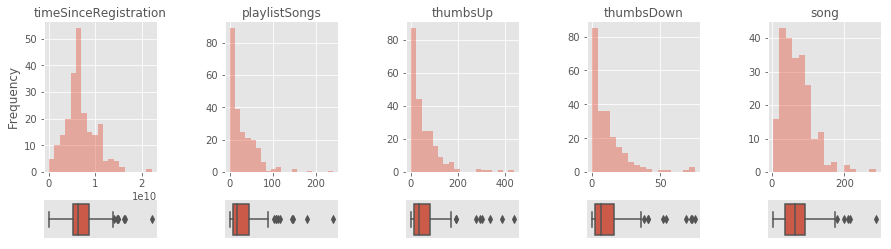

In [73]:
# define continuous features
conFeat = ['timeSinceRegistration', 'playlistSongs', 'thumbsUp', 'thumbsDown', 'song']

# Check distribution of continuous features
check_distribution(features_pd, conFeat)

In [74]:
# apply log to continuous features
featuresNoOut = features.select(col("downgraded"),
                                col("gender_male"),
                                col("level_paid"),
                                F.log(col("timeSinceRegistration") + 1).alias("timeSinceRegistration"),
                                F.log(col("playlistSongs") + 1).alias("playlistSongs"),
                                F.log(col("thumbsUp") + 1).alias("thumbsUp"),
                                F.log(col("thumbsDown") + 1).alias("thumbsDown"),
                                F.log(col("song") + 1).alias("song"),
                                col("churn"))

# create pandas version of dataset
warnings.simplefilter('ignore') # ignore warning due to bug
featuresNoOut_pd = featuresNoOut.toPandas()
warnings.simplefilter('default')

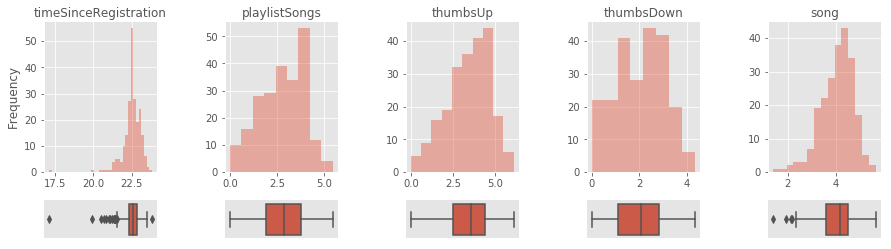

In [75]:
# Check distribution of continuous features again
check_distribution(featuresNoOut_pd, conFeat)

In [76]:
# Check average feature values for each target value after log transformation
featuresNoOut_pd.groupby('churn').mean()

,downgraded,gender_male,level_paid,timeSinceRegistration,playlistSongs,thumbsUp,thumbsDown,song
churn,,,,,,,,
0,0.231214,0.514451,0.745665,22.632942,2.886201,3.518490,2.008114,4.091826
1,0.173077,0.615385,0.692308,22.103498,2.494055,3.000832,1.925091,3.925782


## 3.2 Implementation

### 3.2.1 Split Dataset

In [77]:
# split the full dataset into train, test, and validation sets
train, test, validation = featuresNoOut.randomSplit([0.70, 0.15, 0.15], seed=42)

# display shape of datasets
print('featuresNoOut shape: {}, {}'.format(featuresNoOut.count(), len(featuresNoOut.columns)))
print('train shape: {}, {}'.format(train.count(), len(train.columns)))
print('test shape: {}, {}'.format(test.count(), len(test.columns)))
print('validation shape: {}, {}'.format(validation.count(), len(validation.columns)))

featuresNoOut shape: 225, 9
train shape: 163, 9
test shape: 37, 9
validation shape: 25, 9


In [78]:
# check churn distribution for featuresNoOut
featuresNoOut.select(F.round(F.mean(col("churn")), 4).alias("churnPct_featuresNoOut")).show()

+----------------------+
|churnPct_featuresNoOut|
+----------------------+
|                0.2311|
+----------------------+



In [79]:
# check churn distribution for train
train.select(F.round(F.mean(col("churn")), 4).alias("churnPct_train")).show()

+--------------+
|churnPct_train|
+--------------+
|        0.2515|
+--------------+



In [80]:
# check churn distribution for test
test.select(F.round(F.mean(col("churn")), 4).alias("churnPct_test")).show()

+-------------+
|churnPct_test|
+-------------+
|       0.1622|
+-------------+



In [81]:
# check churn distribution for validation
validation.select(F.round(F.mean(col("churn")), 4).alias("churnPct_validation")).show()

+-------------------+
|churnPct_validation|
+-------------------+
|                0.2|
+-------------------+



### 3.2.2 Resampling
The dataset is very unbalanced with much more 0 than 1 in the target variable (churn). Since some algorithms can be negatively affected by this I've chosen to undersample the majority class. This means that I remove some of the users that have not churned from the training set. The drawback is that we are removing information that could be valuable for the model.

In [82]:
def undersample(df, minority, majority): 
    '''
    Returned new balanced dataset by undersampling the majority class.
    The class name must be 'churn' in the df.
    
    INPUT:
    (dataframe) df - dataframe to be balanced
    (int) minority - minority class value
    (int) majority - majority class value
    
    OUTPUT:
    (dataframe) balDataset - balanced dataset which equal minority and 
                             majority classes
    '''
    
    # find size of minority class
    minoritySize = df.where(df.churn == minority).count()
    
    # create two separate sets of same size
    df_minority = df.where(df.churn == minority)
    df_majority = df.where(df.churn == majority).sample(1.0, seed=42).limit(minoritySize)
    
    # create one dataset
    balDataset = df_minority.union(df_majority)
    
    # return pipeline
    return balDataset

In [83]:
# display distribution before undersampling
train.groupby(train.churn).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   41|
|    0|  122|
+-----+-----+



In [84]:
# undersample training set
train = undersample(train, 1, 0)

In [85]:
# display distribution after undersampling
train.groupby(train.churn).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   41|
|    0|   41|
+-----+-----+



### 3.2.3 Build Pipeline
Build a pipeline and a training function that can be reused. The pipeline perform the following steps:
- Put all features into a vector
- Encode churn column to label indices
- Scale all features to be between 0 and 1
- Run model

In [86]:
def build_pipeline(feature_cols, learner): 
    '''
    Build pipeline of steps to be run when training model.
    
    INPUT:
    (list) feature_cols - list of feature columns to be used
    (clf) learner - the learning algorithm to be trained and predicted on
    
    OUTPUT:
    (pipeline) pipeline - steps in pipeline 
    '''
    
    # create feature vector
    featureAssembler = VectorAssembler(inputCols=feature_cols, outputCol="featuresRaw")
    
    # create label
    labelIndexer = StringIndexer(inputCol="churn", outputCol="label")
    
    # scale data
    scaler = MinMaxScaler(inputCol="featuresRaw", outputCol="features")

    # build pipeline
    pipeline = Pipeline(stages=[featureAssembler, labelIndexer, scaler, learner])
    
    # return pipeline
    return pipeline
    

In [87]:
def train_predict(pipeline, train, test): 
    '''
    Train and predict and return dictionary with results.
    
    INPUT:
    (pipeline) pipeline - steps in pipeline inclusing classifier
    (dataframe) train - features and target training set
    (dataframe) test - features and target testing set
    
    OUTPUT:
    (dict) results - results from training and testing 
    '''
    
    # Dictionary for results
    results = {}
    
    # Fit the pipeline to the training data
    start = time() # Get start time
    model = pipeline.fit(train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = round(end - start, 4)
        
    # Get the predictions
    start = time() # Get start time
    predictions_test = model.transform(test)
    predictions_train = model.transform(train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = round(end - start, 4)

    # compute f1 score on training samples
    predRDD_train = predictions_train.select(['label', 'prediction']) \
                                     .rdd.map(lambda line: (line[1], line[0]))
    metrics_train = MulticlassMetrics(predRDD_train)
    f1Score_train = metrics_train.fMeasure(label=1.0, beta=1.0)
    results['f1_train'] = f1Score_train
    
    # compute f1 score on test samples
    predRDD_test = predictions_test.select(['label', 'prediction']) \
                                   .rdd.map(lambda line: (line[1], line[0]))
    metrics_test = MulticlassMetrics(predRDD_test)
    f1Score_test = metrics_test.fMeasure(label=1.0, beta=1.0)
    results['f1_test'] = f1Score_test
     
    # Return the results
    return results

### 3.2.4 Initial Model Evaluation
As discussed earlier, predicting user churn is a binary classification problem where we can use supervised learning. I will evaluate the following classifiers:

- Logistic Regression
- Decision Tree
- Random Forest
- Naive Bayes

In [88]:
# get start time
start = time()

# select features to use
feature_cols = ["downgraded", "gender_male", "level_paid", "timeSinceRegistration", 
                "playlistSongs", "thumbsUp", "thumbsDown", "song"]

# Initialize four models
clf_LR = LogisticRegression(maxIter=50)
clf_DT = DecisionTreeClassifier(seed=42)
clf_RF = RandomForestClassifier(numTrees=10, seed=42)
clf_NB = NaiveBayes() 

# collect results on the learners
results = {}
for clf in [clf_LR, clf_DT, clf_RF, clf_NB]:
    
    # get and print classifier name
    clf_name = clf.__class__.__name__
    print('{} started'.format(clf_name))
    
    # build pipeline and train model
    pipeline = build_pipeline(feature_cols, clf)
    results[clf_name] = train_predict(pipeline, train, test)

# print time used
time_minutes = round((time()-start)/60, 1)
print('Model evaluation took: {} minutes'.format(time_minutes))
    
# present result
results_df = pd.DataFrame(results)
results_df

LogisticRegression started
DecisionTreeClassifier started
RandomForestClassifier started
NaiveBayes started
Model evaluation took: 14.0 minutes


,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,NaiveBayes
f1_test,0.454545,0.421053,0.476190,0.181818
f1_train,0.800000,0.897436,0.891892,0.582278
pred_time,0.362300,0.353000,0.261700,0.305900
train_time,148.732100,71.997300,79.367400,67.983600


## 3.3 Refinement - Tune Model
Random Forest was chosen to be tuned since it had the highest F1 score during model evaluation. Three different evaluators was tested:
- MulticlassClassificationEvaluator: **f1**
- MulticlassClassificationEvaluator: **weightedPrecision**
- BinaryClassificationEvaluator: **areaUnderROC**

The binary classification evaluator was chosen in the end as it produced the best result.

In [141]:
# Get start time
start = time() 

# get results for unoptimized model
f1_unoptimized = round(results_df.loc['f1_test', 'RandomForestClassifier'], 4)
print("Unoptimized model: F1 score on testing data: {:.4f}".format(f1_unoptimized))

# build pipeline
pipeline_tuned = build_pipeline(feature_cols, clf_RF)

# define hyperparameters 
paramGrid = ParamGridBuilder() \
    .addGrid(clf_RF.numTrees,[4, 7, 10]) \
    .addGrid(clf_RF.maxDepth,[3, 5, 7]) \
    .addGrid(clf_RF.minInstancesPerNode,[2, 4]) \
    .addGrid(clf_RF.seed,[42]) \
    .build()

# cross validation
crossval = CrossValidator(estimator=pipeline_tuned,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                          numFolds=3,
                          seed=42)

# train model
cvModel = crossval.fit(train)

# make predictions using tuned model on test
pred_tuned = cvModel.transform(test)

# compute f1 score on predictions
predRDD_tuned = pred_tuned.select(['label', 'prediction']) \
                          .rdd.map(lambda line: (line[1], line[0]))
metrics_tuned = MulticlassMetrics(predRDD_tuned)
f1Score_tuned = metrics_tuned.fMeasure(label=1.0, beta=1.0)
print("Optimized model: F1 score on testing data: {:.4f}".format(f1Score_tuned))

# print time used
time_minutes = round((time()-start)/60, 1)
print('Tuning took: {} minutes'.format(time_minutes))

Unoptimized model: F1 score on testing data: 0.4762
Optimized model: F1 score on testing data: 0.5263
Tuning took: 23.5 minutes


In [142]:
# check which parameters worked best
cvModel.bestModel.stages[-1].extractParamMap()

{Param(parent='RandomForestClassifier_aecb52a0c13f', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_aecb52a0c13f', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_aecb52a0c13f', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_aecb52a0c13f', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_aecb52a0c13f', 

----
# 4. Results

## 4.1 Model Evaluation
For the model evaluation we use the validation dataset which the model haven't seen before. We use the F1 score as the metric to evaluate and make sure that a user churning is the positive event. This is important since we have a lot more users which didn't churn in the data, and choosing this as the positive event would inflate the score.

### 4.1.1 F1 Score


In [143]:
# make predictions using tuned model on validation dataset
pred_validation = cvModel.transform(validation)

# compute f1 score on predictions
predRDD_valid = pred_validation.select(['label', 'prediction']) \
                               .rdd.map(lambda line: (line[1], line[0]))
metrics_valid = MulticlassMetrics(predRDD_valid)
f1Score_valid = metrics_valid.fMeasure(label=1.0, beta=1.0)

# display result
print("Optimized model: F1 score on validation data: {:.4f}".format(f1Score_valid))

Optimized model: F1 score on validation data: 0.4615


### 4.1.2 Confusion Matrix
To take a closer look at the validation predictions we create a confusion matrix. The actual values are displayed as rows and predicted values as columns. When considering a user churning as a positive event we see that:
- **True Positive**: 3 users have a positive actual value and prediction is also positive
- **False Negative**: 2 users have a positive actual value but prediction is negative
- **False Positive**: 5 users have a negative actual value but prediction is positive
- **True Negative**: 20 users have a negative actual value and prediction is also negative

In other words, our model correctly predicted 15 out of 20 users as not churning. However, it only correctly predicted 3 out of 5 users as churning so it's not performing as good as one might hope. 

In [144]:
# create confusion matrix
confMatrix = metrics_valid.confusionMatrix().toArray()

# convert to pandas
confMatrix_pd=pd.DataFrame(confMatrix, columns=['0', '1']) 
confMatrix_pd = confMatrix_pd.astype(int)
confMatrix_pd.head()

,0,1
0,15,5
1,2,3


In [145]:
# check all validation predictions
firstElement=udf(lambda v:float(v[0]))
secondElement=udf(lambda v:float(v[1]))
pred_validation.select(['label', 'prediction', 
                        F.round(firstElement('probability'), 2).alias('0_probability'),
                        F.round(secondElement('probability'), 2).alias('1_probability')]).show(25)

+-----+----------+-------------+-------------+
|label|prediction|0_probability|1_probability|
+-----+----------+-------------+-------------+
|  0.0|       0.0|         0.81|         0.19|
|  0.0|       0.0|         0.53|         0.47|
|  1.0|       0.0|         0.77|         0.23|
|  0.0|       0.0|         0.53|         0.47|
|  0.0|       1.0|         0.24|         0.76|
|  1.0|       1.0|         0.29|         0.71|
|  1.0|       1.0|         0.14|         0.86|
|  1.0|       1.0|         0.47|         0.53|
|  0.0|       0.0|         0.63|         0.37|
|  0.0|       0.0|         0.77|         0.23|
|  0.0|       0.0|         0.63|         0.37|
|  0.0|       0.0|         0.77|         0.23|
|  0.0|       0.0|         0.64|         0.36|
|  0.0|       1.0|         0.49|         0.51|
|  0.0|       0.0|         0.77|         0.23|
|  0.0|       1.0|         0.49|         0.51|
|  0.0|       0.0|         0.77|         0.23|
|  0.0|       0.0|         0.77|         0.23|
|  0.0|      

## 4.2 Justification
When evaluating the model it got a F1 score of **46.2%** which is not very good. When looking closer at the result via a confusion matrix we saw that the model only predicted 3 out of 5 churning users correctly. As the dataset available was very small, it's hard to trust the model in it's current state. It should be trained and validated further on a greater dataset.

At the moment no threshold tuning have been done. This means that the target class with the highest probability will be chosen (>50% probability). If we could get the "cost" of a churning customer and compare that against the cost of the activities for keeping the customer, we could do a cost-benefit analysis of different threshold scenarios. We could make the model catch more of the churn users, but that would come with the trade-of of also incorrectly flagging more of the not churning users as churning.

----
# 5. Conclusion

## 5.1 Reflection
In this project I set out to predict which users would churn from the Sparkify music streaming service. I found out that this would be a binary classification problem and decided to use supervised learning using Spark machine learning. First I did some data exploration to get a feel for the data. I then continued building features. Once I had a dataset ready I trained 4 different types of models. The Random Forest classifier performed the best and I then further tuned this model using different hyperparameters and cross validation.

In the end I evaluated the model on a previous unseen dataset where the model got an F1 score of **46.2%** which was not that good. When looking closer at the result via a confusion matrix we saw that the model only predicted 3 out of 5 churning users correctly. However, the model should be trained and validated further on a bigger dataset as the data available for this workspace was very limited. 

As a long-term user of the Spotify music streaming service, I found the feature engineering part particulary interesting. It was fun trying out some ideas I've been thinking about for a while as a user. Unfortunatly I couldn't try out all of my ideas since data needed was not provided. One such idea is that the number of playlists a user has, "lock" him to a service since it would be too much work recreating many playlists with another service.

## 5.2 Improvement
The model could be improved by being trained on a bigger dataset. In addition more parameters and parameter values could be tested during hyperparameter tuning. Both of these improvements would require more computing power, so the project would probably benefit from being moved on to AWS or similar cloud service.

Another improvement could be to try out more features. Here are some ideas:
- How many times a user has been on the cancel page without confirming
- Average time between sessions
- Average session length
- Songs listened to last month compared to average last 6 months
- Time since last session